# Libraries

In [54]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict, Counter
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

# machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# graphs
import matplotlib.pyplot as plt
import seaborn as sns

# read in data

In [21]:
market_cap_df = pd.read_csv('../data/market_cap.csv').T
# rename columns
market_cap_df.columns = market_cap_df.loc['Quarter']
# Drop the 'Quarter' row
market_cap_df.drop('Quarter', inplace=True)

# Analysis

### descriptive

In [22]:
# Function to classify companies based on market cap
def classify_market_cap(market_cap):
    if market_cap < 300000000:
        return 'Micro-Cap'
    elif 300000000 <= market_cap < 2000000000:
        return 'Small-Cap'
    elif 2000000000 <= market_cap < 10000000000:
        return 'Mid-Cap'
    elif 10000000000 <= market_cap < 200000000000:
        return 'Large-Cap'

# Get the market cap for the first and last quarter for each company
first_quarter = market_cap_df.iloc[:,0]

# Classify companies based on their market cap for the first and last quarter
market_cap_df['market_cap_start'] = first_quarter.apply(classify_market_cap)

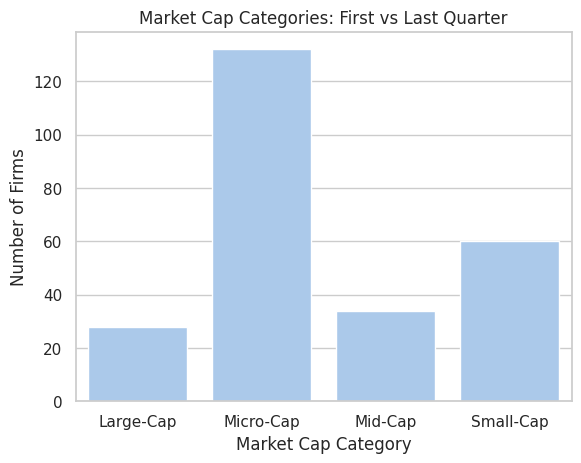

In [23]:
def count_firms_by_category(classification_series):
    return classification_series.value_counts().sort_index()

def plot_combined_firm_categories(title):
    # Combine the two Series into a DataFrame
    combined_df = pd.DataFrame({
        'First_Quarter': count_firms_by_category(market_cap_df['market_cap_start'])
    }).fillna(0)  # Fill NaNs with 0
        
    # Set the style and palette
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create the barplot
    sns.barplot(x='market_cap_start', y='First_Quarter', data=combined_df)
    
    # Add labels and title
    plt.title(title)
    plt.xlabel('Market Cap Category')
    plt.ylabel('Number of Firms')
    
    # Show the plot
    plt.show()

# Usage Example
plot_combined_firm_categories('Market Cap Categories: First vs Last Quarter')


### Clustering

##### relative price changes

stock splits are being interpolated linearly, since they would otherwise be seen as outliers

In [24]:
# Reverse the DataFrame order
reversed_df = market_cap_df.iloc[:, :-1]

# Calculate the percentage change
relative_changes_df = reversed_df.pct_change(axis=1)

# The first column will now have NaN values because there is no previous timestamp to compare to
# You may want to drop it or fill it with zeros
relative_changes_df = relative_changes_df.fillna(0)

# Define a function to detect outliers
def detect_outliers(df, std_dev_factor=2):
    outlier_mask = df.apply(lambda x: np.abs(x - x.mean()) > (std_dev_factor * x.std()), axis=0)
    return outlier_mask

# Detect outliers in the entire DataFrame
outlier_mask = detect_outliers(relative_changes_df)

# Replace outliers with NaN
relative_changes_df[outlier_mask] = np.nan

# Interpolate the NaN values linearly across each column
relative_changes_df.interpolate(method='linear', limit_direction='both', axis=0, inplace=True)

/tmp/ipykernel_313/3634292921.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  relative_changes_df = reversed_df.pct_change(axis=1)


##### best k

Calculating Best k: 100%|██████████| 9/9 [00:00<00:00, 40.23it/s]

Silhouette score for k=2: 0.06522639174465879
Silhouette score for k=5: 0.03187209127239874
Silhouette score for k=3: 0.056837178851808244
Silhouette score for k=4: 0.050024524706282006
Silhouette score for k=7: 0.004535420240466143
Silhouette score for k=6: 0.043908402973291114
Silhouette score for k=9: 0.014318054162046236
Silhouette score for k=8: 0.023259572401989122
Silhouette score for k=10: 0.0032525099986953944


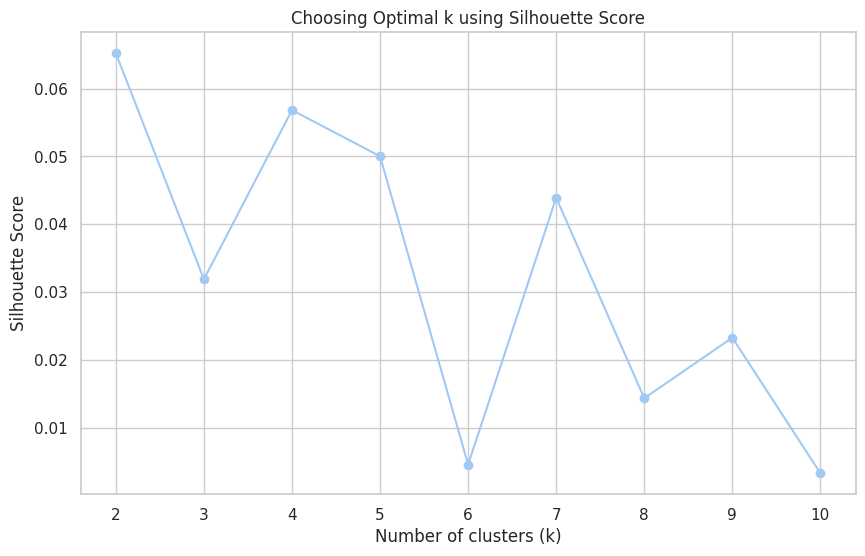

In [25]:
def calculate_silhouette(k, df_scaled):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_scaled, labels)
    return silhouette_avg

def best_k(data, highest_k):
    df = data.fillna(0)
    
    # Standardize the columns
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    # Initialize list to store silhouette_scores
    silhouette_scores = []
    
    k_values = range(2, highest_k)
    
    # Use ThreadPoolExecutor to parallelize the calculation
    with ThreadPoolExecutor() as executor:
        future_to_k = {executor.submit(calculate_silhouette, k, df_scaled): k for k in k_values}
        for future in tqdm(as_completed(future_to_k), total=len(k_values), desc='Calculating Best k'):
            k = future_to_k[future]
            try:
                silhouette_score = future.result()
                silhouette_scores.append(silhouette_score)
                print(f"Silhouette score for k={k}: {silhouette_score}")
            except Exception as exc:
                print(f'Generated an exception for k={k}: {exc}')
    
    # Check if silhouette_scores is empty
    if not silhouette_scores:
        print("No silhouette scores were calculated. Please check the exceptions above.")
        return
    
    # Plot the silhouette_scores against k_values
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Choosing Optimal k using Silhouette Score')
    plt.show()

# Call the function with the DataFrame excluding the last column
best_k(relative_changes_df, 11)


##### cluster graph

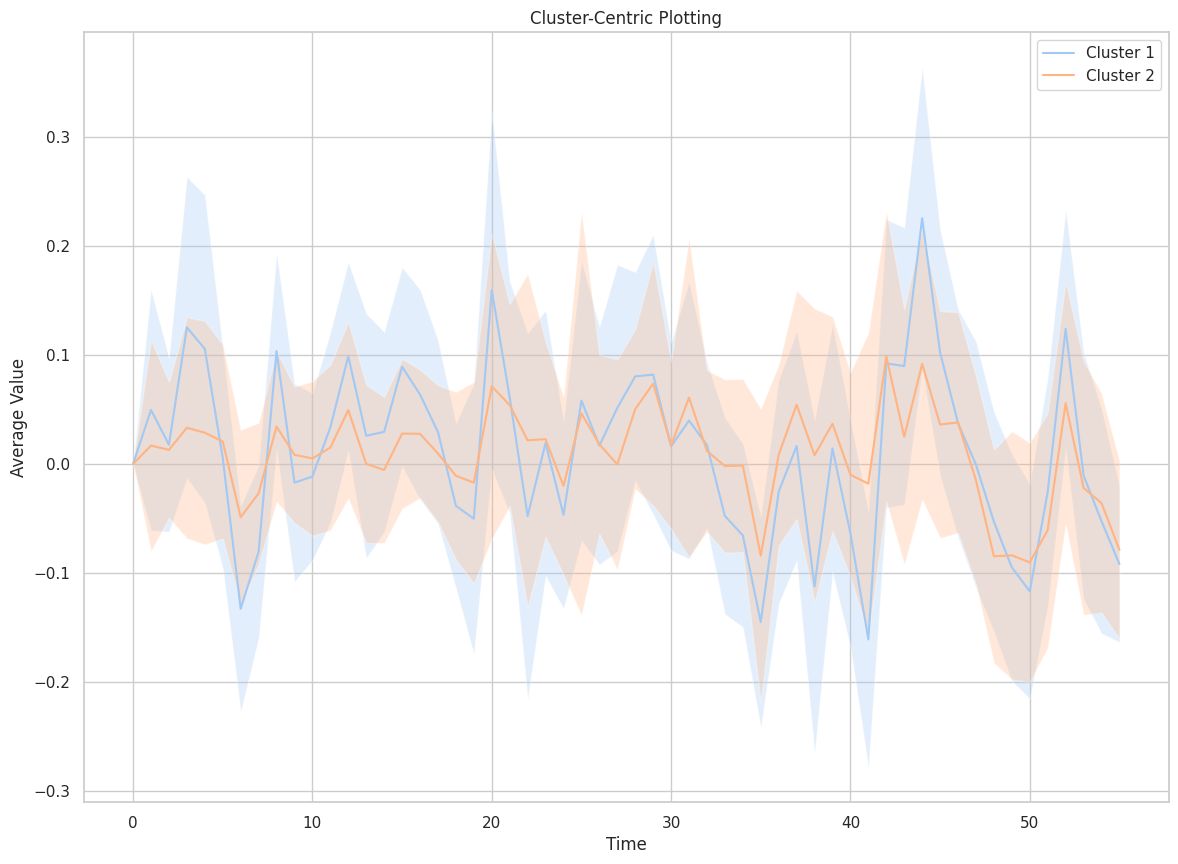

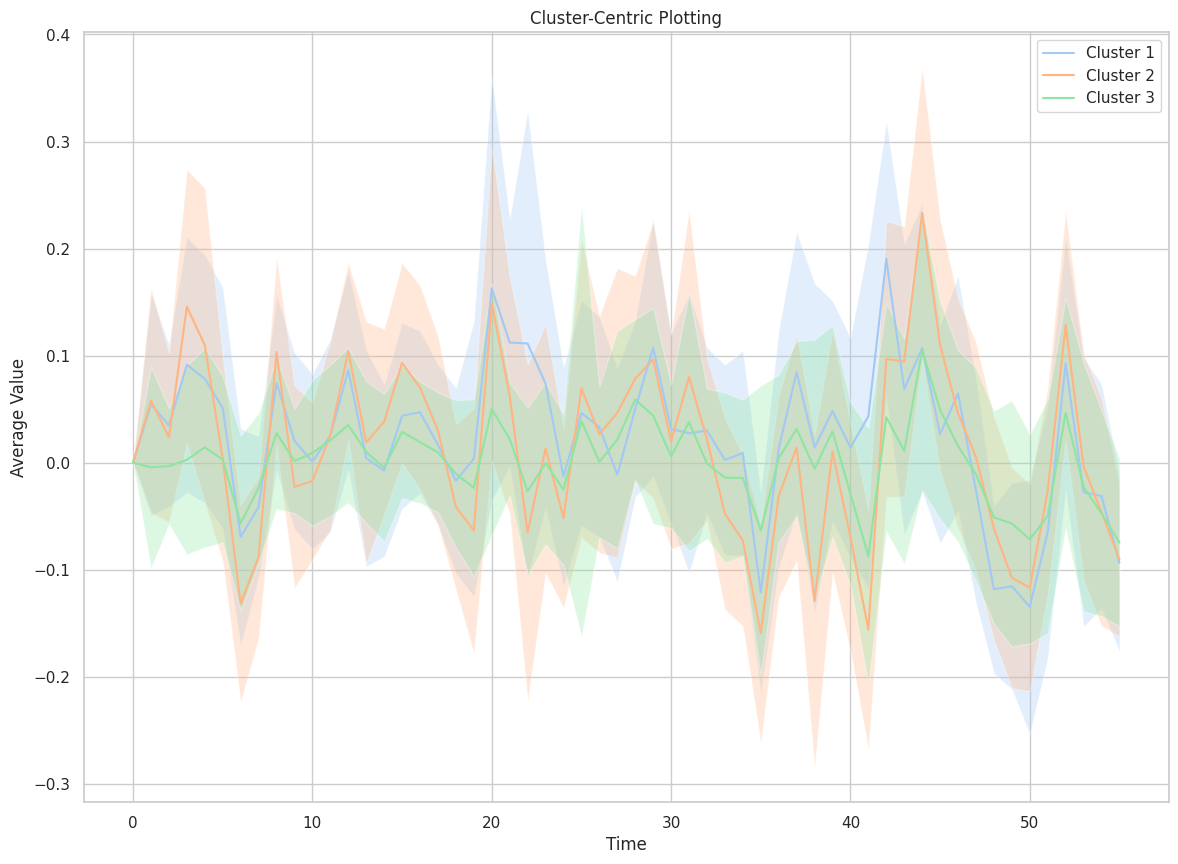

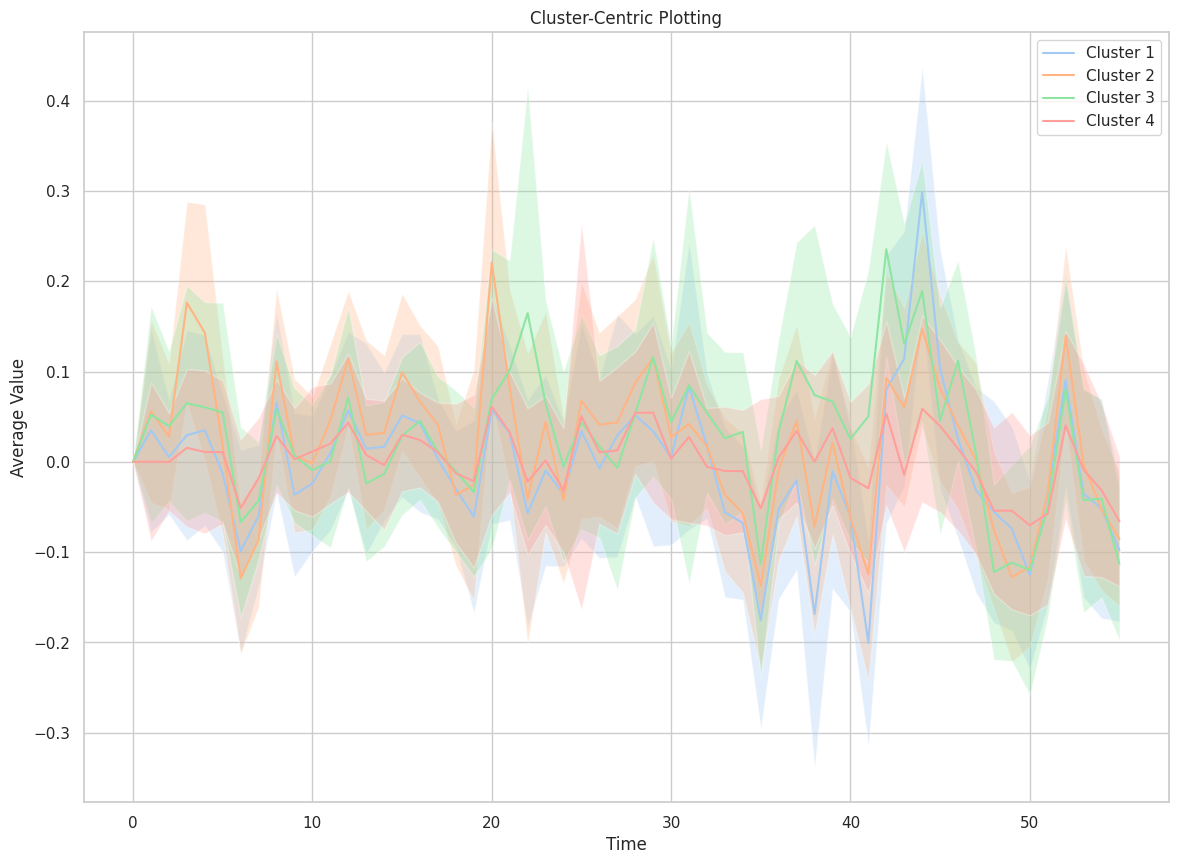

In [26]:
def cluster_centric_plotting(data, best_k):
    df = data.fillna(0).copy()  # Create a copy to work with
    df.columns = range(0,df.shape[1])

    # Perform clustering
    kmeans = KMeans(n_clusters=best_k, n_init=10)
    kmeans.fit(df)
    labels = kmeans.labels_
    
    # Add cluster labels to the dataframe
    df['Cluster'] = labels
    # Initialize the plot
    plt.figure(figsize=(14, 10))
    
    # Plot the average time series for each cluster
    for i in range(best_k):
        cluster_data = df[df['Cluster'] == i].drop(['Cluster'], axis=1)
        
        # Calculate the average time series for this cluster
        cluster_average = cluster_data.mean(axis=0)
        
        # Calculate the standard deviation for this cluster
        cluster_std = cluster_data.std(axis=0)
        
        # Convert to numpy arrays and remove NaNs and infs
        x_values = np.array(cluster_average.index, dtype=float)
        y_values = np.array(cluster_average.values, dtype=float)
        y_values_std = np.array(cluster_std.values, dtype=float)
        
        x_values = x_values[np.isfinite(y_values)]
        y_values_std = y_values_std[np.isfinite(y_values)]
        y_values = y_values[np.isfinite(y_values)]

        # Plot the average time series
        plt.plot(x_values, y_values, label=f'Cluster {i+1}')
        
        # Plot the shaded region for standard deviation
        plt.fill_between(x_values,
                         y_values - y_values_std,
                         y_values + y_values_std,
                         alpha=0.3)
    
    plt.title('Cluster-Centric Plotting')
    plt.xlabel('Time')
    plt.ylabel('Average Value')
    plt.legend()
    plt.show()


k_list = [2, 3, 4]

for k in k_list:
    cluster_centric_plotting(relative_changes_df, k)

##### Cluster Analysis

In [27]:
def clustering(data, target_df, k):
    # Perform clustering
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    labels = kmeans.labels_
    target_df['Cluster'] = labels

    return target_df

market_cap_df = clustering(relative_changes_df, market_cap_df, 3)

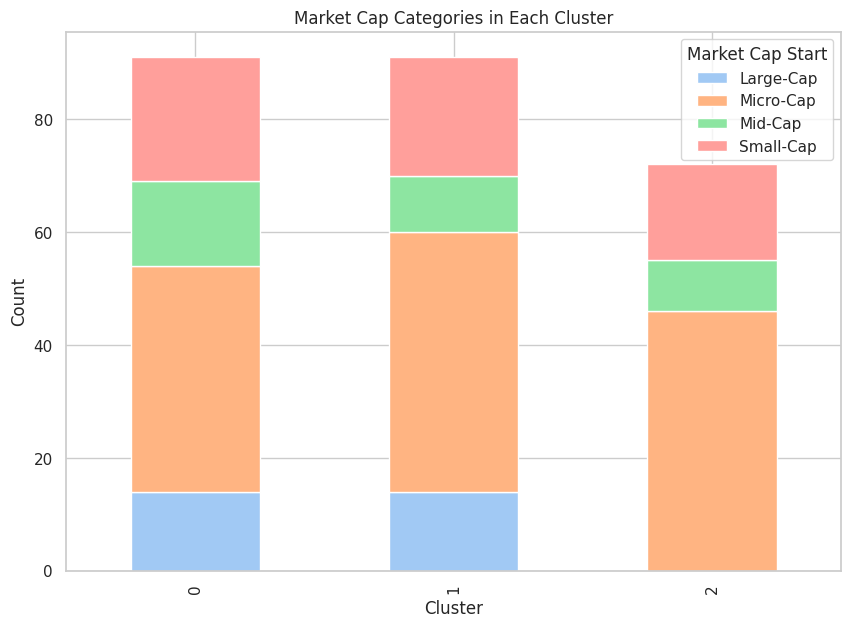

In [28]:
# Group by 'Cluster' and 'market_cap_start' and count the occurrences
cluster_market_cap_counts = market_cap_df.groupby(['Cluster', 'market_cap_start']).size().reset_index(name='Count')

# Pivot the DataFrame to get market cap categories as columns
pivot_df = cluster_market_cap_counts.pivot(index='Cluster', columns='market_cap_start', values='Count')

# Plot a stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Market Cap Categories in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Market Cap Start')
plt.show()

# size effect

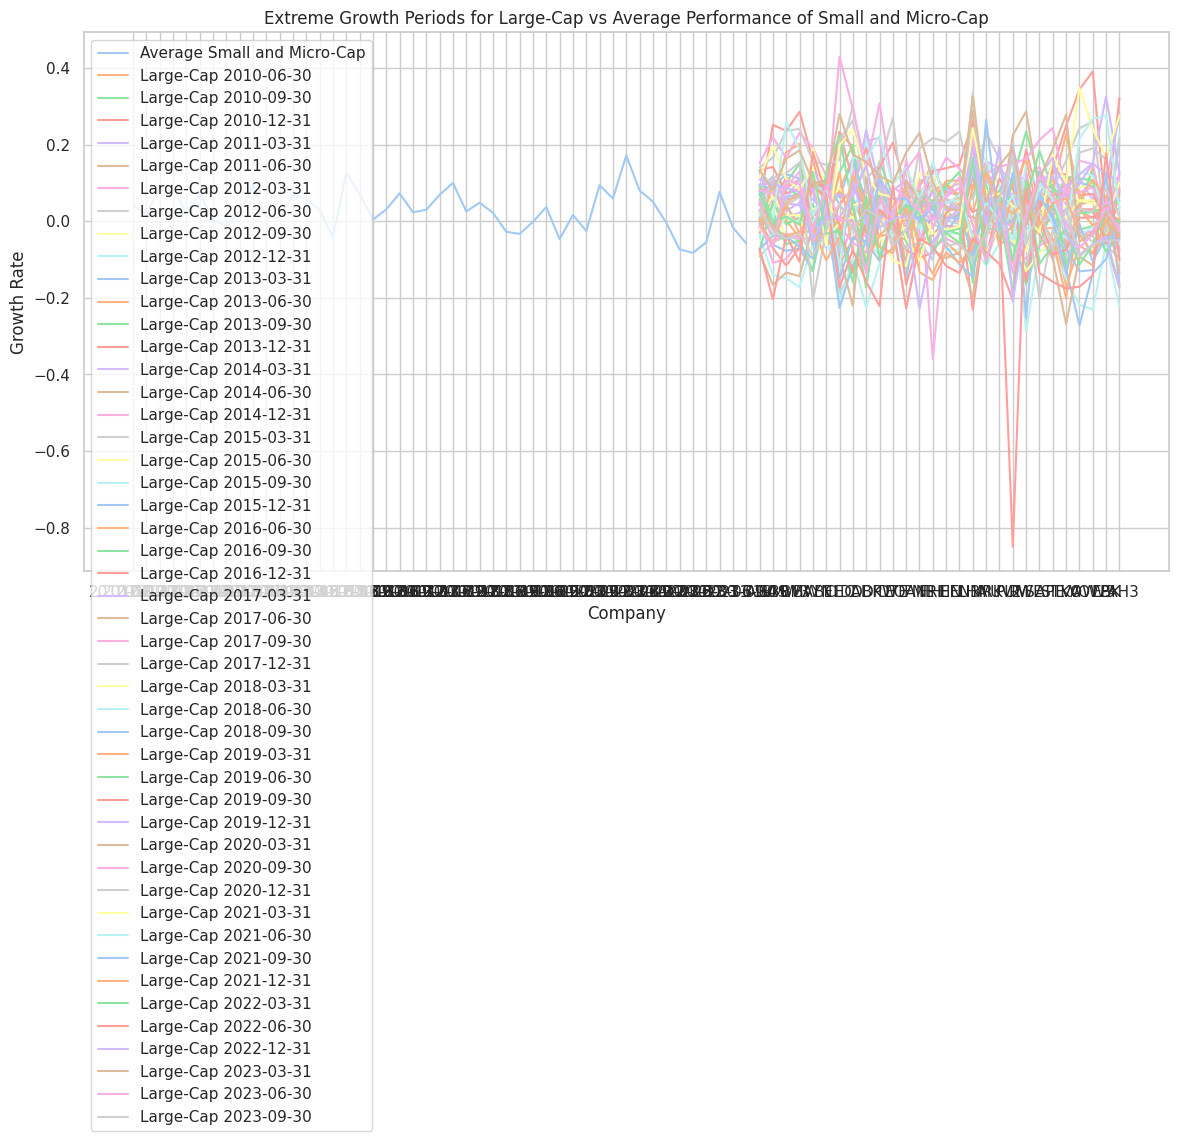

In [41]:
relative_changes_df['market_cap'] = market_cap_df['market_cap_start']

def size_effect(data, growth_threshold):
    # Check if 'market_cap' column exists
    if 'market_cap' not in data.columns:
        raise KeyError("The DataFrame does not contain a 'market_cap' column.")
        
    # Step 1: Filter for Large-Cap companies
    large_caps = data[data['market_cap'] == 'Large-Cap']

    # Step 2: Identify extreme growth periods
    extreme_growth_periods = (large_caps.drop(columns=['market_cap']) > growth_threshold).any()

    # Step 3: Extract the same periods for Small and Micro-Cap companies
    small_micro_caps = data[data['market_cap'].isin(['Small-Cap', 'Micro-Cap'])]
    # Ensure we're using the column names to index, which should be aligned
    target_periods = small_micro_caps.loc[:, extreme_growth_periods[extreme_growth_periods].index]

    # Step 4: Calculate average performance for Small and Micro-Cap companies
    average_performance = target_periods.mean()

    # Step 5: Compare performance
    # You can now compare the extreme growth periods of Large-Cap companies
    # with the average performance of Small and Micro-Cap companies
    # This could be done through visualizations or statistical summaries

    # For example, to visualize:
    plt.figure(figsize=(14, 7))
    plt.plot(target_periods.columns, average_performance.values, label='Average Small and Micro-Cap')
    for period in extreme_growth_periods[extreme_growth_periods].index:
        # Use the DataFrame index for the x-axis
        plt.plot(large_caps.index, large_caps[period], label=f'Large-Cap {period}')
    plt.legend()
    plt.title('Extreme Growth Periods for Large-Cap vs Average Performance of Small and Micro-Cap')
    plt.xlabel('Company')
    plt.ylabel('Growth Rate')
    plt.show()


size_effect(relative_changes_df, 0.1)

In [122]:
from collections import Counter

def size_effect(data, growth_threshold):
    # Check if 'market_cap' column exists
    if 'market_cap' not in data.columns:
        raise KeyError("The DataFrame does not contain a 'market_cap' column.")
        
    # Step 1: Filter for Large-Cap companies
    large_caps = data[data['market_cap'] == 'Large-Cap']
    large_caps_growth = large_caps.drop(columns=['market_cap']).mean(axis=0)

    # Step 2: Identify extreme growth periods for Large-Cap companies
        # Growth
    extreme_growth_periods = large_caps_growth > growth_threshold
    extreme_growth_quarters = extreme_growth_periods[extreme_growth_periods].index
        # Loss
    extreme_loss_periods = large_caps_growth < (growth_threshold * -1)
    extreme_loss_quarters = extreme_loss_periods[extreme_loss_periods].index

    # Step 3: Extract the same periods for Small-Cap companies
    small_caps = data[data['market_cap'].isin(['Small-Cap', 'Micro-Cap'])]
    small_caps_growth = small_caps.loc[:, extreme_growth_quarters]
    small_caps_loss = small_caps.loc[:, extreme_loss_quarters]

    # Step 4: Calculate average performance for Small-Cap companies
    average_performance = small_caps_growth.mean(axis=0)
    average_loss = small_caps_loss.mean(axis=0)

    # Step 5: Determine how many Small-Cap companies exceeded the Large-Cap growth
    # Align the large_caps_growth Series with the small_caps_growth DataFrame along the columns
    exceeded_growth = (average_performance > large_caps_growth[extreme_growth_periods]).sum(axis=0)
    under_growth = (average_performance < large_caps_growth[extreme_growth_periods]).sum(axis=0)

    minimized_loss = (average_loss < large_caps_growth[extreme_loss_periods]).sum(axis=0)
    worse_loss = (average_loss > large_caps_growth[extreme_loss_periods]).sum(axis=0)

    print(f"Extreme growth periods: {extreme_growth_periods.sum(axis=0)} {extreme_growth_quarters.tolist()}")
    print(f"Number of times measurable size effect: {exceeded_growth}")
    print(f"Number of times absent size effect: {under_growth}")

    print(f"Extreme growth periods: {extreme_loss_periods.sum(axis=0)} {extreme_loss_quarters.tolist()}")
    print(f"Number of times size effect reduces loss: {minimized_loss}")
    print(f"Number of times size effect worsenes loss: {worse_loss}")

size_effect(relative_changes_df, 0.1)


Extreme growth periods: 6 ['2010-12-31', '2012-03-31', '2015-03-31', '2020-09-30', '2021-03-31', '2023-03-31']
Number of times measurable size effect: 1
Number of times absent size effect: 5
Extreme growth periods: 3 ['2011-09-30', '2015-09-30', '2020-06-30']
Number of times size effect reduces loss: 0
Number of times size effect worsenes loss: 3


# Test Area